In [1]:
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Engine():
    """The engine is the main object that will be used to run our backtest.
    """
    def __init__(self, initial_cash = 100000):
        self.strategy = None
        self.cash = initial_cash
        self.data = None
        self.current_idx = None
        self.initial_cash = initial_cash
        self.cash_series = {}
        self.stock_series = {}
        self.trading_days_per_year = 365
        self.risk_free_rate = 0
    
    def add_data(self, data:pd.DataFrame):
        # Add OHLC Data to The Engine
        self.data = data
    
    def add_strategy(self, strategy):
        # Add a strategy to the engine
        self.strategy = strategy
        
    def run(self):
        # We need to preprocess a few things before running the backtest
        self.strategy.data = self.data
        self.strategy.cash = self.cash
        
        for idx in tqdm(self.data["Date"]):
            self.current_idx = idx
            self.strategy.current_idx = self.current_idx
            # fill orders from previous period
            self._fill_orders()
            
            # Run the strategy on the current bar
            self.strategy.give_new_orders()
            self.cash_series[idx] = self.cash
            self.stock_series[idx] = self.strategy.position_size * self.data[self.data['Date'] == self.current_idx]['Close'].values[0]
        
        return self._get_stats()

    def _fill_orders(self):
        """this method fills buy and sell orders, creating new trade objects and adjusting the strategy's cash balance.
        Conditions for filling an order:
        - If we're buying, our cash balance has to be large enough to cover the order.
        - If we are selling, we have to have enough shares to cover the order.
        """
        
        for order in self.strategy.orders:
            can_fill = False
            open_price = self.data[self.data['Date'] == self.current_idx]['Open'].values[0]
            close_price = self.data[self.data['Date'] == self.current_idx]['Close'].values[0]
            low_price = self.data[self.data['Date'] == self.current_idx]['Low'].values[0]
            high_price = self.data[self.data['Date'] == self.current_idx]['High'].values[0]
            fill_price = open_price
            if order.side == 'buy' and self.cash >= self.data[data['Date']==self.current_idx]['Open'].values[0] * order.size:
                if order.type == 'limit':
                    limit_price = order.limit_price
                    if limit_price >= low_price:
                        fill_price = limit_price
                        can_fill = True
#                         print(self.current_idx, 'Buy Filled. ', "limit ",limit_price," / low", low_price)
                    else:
                        pass
#                         print(self.current_idx, 'Buy Not Filled. ', "limit ",limit_price," / low", low_price)
                else:
                    can_fill = True
            elif order.side == 'sell' and self.strategy.position_size >= order.size:
                if order.type == 'limit':
                    limit_price = order.limit_price
                    if limit_price <= high_price:
                        fill_price = limit_price
                        can_fill = True
#                         print(self.current_idx,'Sell Filled. ', "limit ",limit_price," / high", high_price)
                    else:
                        pass
#                         print(self.current_idx,'Sell Not Filled. ', "limit ",limit_price," / high", high_price)
                else:
                    can_fill = True
            
            if can_fill:
                t = Trade(
                side = order.side,
                price = fill_price,
                size = order.size,
                _type = order.type,
                idx = self.current_idx)
                
                self.strategy.trades.append(t)
                self.cash -= t.price * t.size
            
        self.strategy.cash = self.cash
        self.strategy.orders = []
    
    def _get_stats(self):
        metrics = {}
        ## Total Return
        total_return = 100*((self.data[self.data['Date'] == self.current_idx]['Close'].values[0]*self.strategy.position_size + self.cash)/self.initial_cash - 1)
        metrics['total_return'] = total_return
        ## Buy and Hold Portfolio
        portfolio_bh = self.initial_cash / self.data.loc[self.data.index[0]]['Open'] * self.data.Close
        ## Our Portfolio
        portfolio = pd.DataFrame({'stock':self.stock_series, 'cash':self.cash_series})
        portfolio['total_aum'] = portfolio['stock'] + portfolio['cash']
        ## Mean Exposure
        metrics['exposure_pct'] = ((portfolio['stock'] / portfolio['total_aum']) * 100).mean()
        # Calculate annualized returns
        p = portfolio.total_aum
        metrics['returns_annualized'] = ((p.iloc[-1] / p.iloc[0]) ** (1 / (len(p) / 365)) - 1) * 100
        p_bh = portfolio_bh
        metrics['returns_bh_annualized'] = ((p_bh.iloc[-1] / p_bh.iloc[0]) ** (1 / (len(p_bh) / 365)) - 1) * 100
        metrics['volatility_ann'] = p.pct_change().std() * np.sqrt(self.trading_days_per_year) * 100
        metrics['volatility_bh_ann'] = p_bh.pct_change().std() * np.sqrt(self.trading_days_per_year) * 100
        metrics['sharpe_ratio'] = (metrics['returns_annualized'] - self.risk_free_rate) / metrics['volatility_ann']
        metrics['sharpe_ratio_bh'] = (metrics['returns_bh_annualized'] - self.risk_free_rate) / metrics['volatility_bh_ann']
        self.portfolio = portfolio
        self.portfolio_bh = portfolio_bh
        return metrics
    
    def plot(self):
        plt.plot(self.portfolio['total_aum'],label='Strategy')
        plt.plot(self.portfolio_bh,label='Buy & Hold')
        plt.legend()
        plt.show()
    
    

In [3]:
class Strategy():
    """This base class will handle the execution logic of our trading strategies
    """
    def __init__(self):
        self.current_idx = None
        self.data = None
        self.orders = []
        self.trades = []
        self.cash = None
        
    def buy(self,size=1):
        self.orders.append(
            Order(
                side = 'buy',
                size = size,
                idx = self.current_idx
            ))
    
    def sell(self,size=1):
        self.orders.append(
            Order(
                side = 'sell',
                size = -size,
                idx = self.current_idx
            ))
        
    def buy_limit(self,limit_price, size=1):
        self.orders.append(
            Order(
                side = 'buy',
                size = size,
                limit_price=limit_price,
                order_type='limit',
                idx = self.current_idx
            ))
    
    def sell_limit(self,limit_price, size=1):
        self.orders.append(
            Order(
                side = 'sell',
                size = -size,
                limit_price=limit_price,
                order_type='limit',
                idx = self.current_idx
            ))
    
        
    @property
    def position_size(self):
        return sum([t.size for t in self.trades])
    
    @property
    def close(self):
        return self.data[self.data['Date'] == self.current_idx]['Close'].values[0]
        
    def give_new_orders(self):
        """This method will be overriden by our strategies.
        """
        pass
    

In [4]:
class Trade():
    """Trade objects are created when an order is filled.
    """
    def __init__(self,side,size,price,_type,idx):
        self.side = side
        self.price = price
        self.size = size
        self.type = _type
        self.idx = idx
        
    def __repr__(self):
        return f'<Trade: {self.idx} {self.size}@{self.price}>'

In [5]:
class Order():
    """When buying or selling, we first create an order object. If the order is filled, we create a trade object.
    """
    def __init__(self, size, side, idx, limit_price=None, order_type='market'):
        self.side = side
        self.size = size
        self.idx = idx
        self.type = order_type
        self.limit_price = limit_price


In [6]:
class BuyAndSellSwitch(Strategy):
    def give_new_orders(self):
        if self.position_size == 0:
            limit_price = self.close * 0.995
            self.buy_limit(size=20,limit_price=limit_price)
#             print(self.current_idx,"buy")
        else:
            limit_price = self.close * 1.005
            self.sell_limit(size=20,limit_price=limit_price)
#             print(self.current_idx,"sell")

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2538/2538 [00:03<00:00, 817.22it/s]


{'total_return': 867.4727559999718, 'exposure_pct': 23.328504866092324, 'returns_annualized': 39.377169305063184, 'returns_bh_annualized': 67.30717327332414, 'volatility_ann': 30.439760671078265, 'volatility_bh_ann': 75.07720953296655, 'sharpe_ratio': 1.2936096880182315, 'sharpe_ratio_bh': 0.8965060594556252}


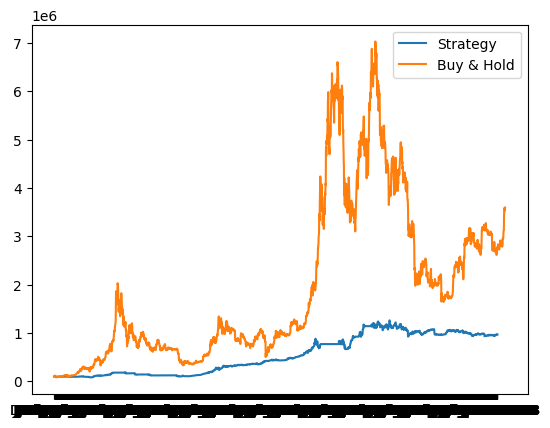

In [7]:
data = pd.read_csv("../sorted_master_table.csv")
e = Engine()
e.add_data(data)
e.add_strategy(BuyAndSellSwitch())
metrics = e.run()
print(metrics)
e.plot()

In [8]:
class SMACrossover(Strategy):
    def give_new_orders(self):
        if self.position_size == 0:
            if self.data[self.data['Date'] == self.current_idx]['sma_12'].values[0] > self.data[self.data['Date'] == self.current_idx]['sma_24'].values[0]:
                limit_price = self.close * 0.997
                order_size = self.cash / limit_price
                self.buy_limit(size=order_size, limit_price=limit_price)
        elif self.data[self.data['Date'] == self.current_idx]['sma_12'].values[0] < self.data[self.data['Date'] == self.current_idx]['sma_24'].values[0]:
            limit_price = self.close * 1.003
            self.sell_limit(size=self.position_size, limit_price=limit_price)
            

100%|████████████████████████████████████████████████████████████████████████████████████████| 2538/2538 [00:01<00:00, 1494.86it/s]


{'total_return': 1045.8684534334207, 'exposure_pct': 34.4689378757515, 'returns_annualized': 42.87082828908477, 'returns_bh_annualized': 67.30717327332414, 'volatility_ann': 45.863135751382046, 'volatility_bh_ann': 75.07720953296655, 'sharpe_ratio': 0.9347557158211297, 'sharpe_ratio_bh': 0.8965060594556252}


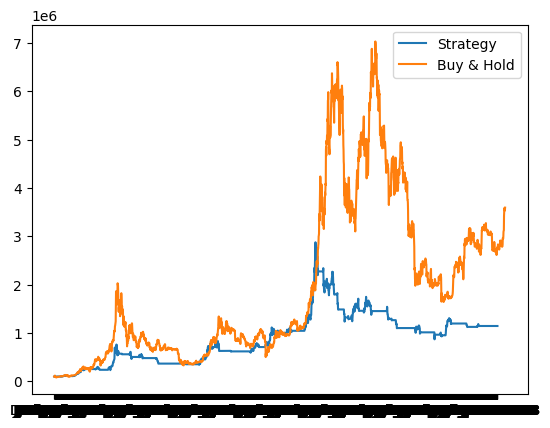

In [9]:
data['sma_12'] = data.Close.rolling(12).mean()
data['sma_24'] = data.Close.rolling(24).mean()
e = Engine(initial_cash=100000)
e.add_data(data)
e.add_strategy(SMACrossover())
stats = e.run()
print(stats)
e.plot()